In [194]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import statsmodels.api as sm
import pytensor.tensor as pt
from pytensor import function
from pytensor.printing import Print

[-0.10361488 -0.44538606  1.03383536 -0.47070244  0.16354743 -0.46414996
  1.03204832 -0.45670397  0.25275046 -0.46534132  1.17501143 -0.29557263
  0.04500719 -0.57032986  1.24083402 -0.27025625  0.10948951 -0.52937688
  1.53644003 -0.44434362  0.03875255 -0.79936867  1.4606398  -0.50971945
  0.07836525 -0.97271144  1.31603858 -0.80919738  0.13138073 -0.91210104
  1.15297128 -0.6327273  -0.08455313 -0.89006089  1.31380478 -0.45000257
  0.06823869 -0.84717196  1.34999231 -0.7809026   0.38141725 -0.77986016
  1.34478012 -0.51299569  0.3787367  -0.8833595   1.40211428 -0.4951253
  0.34865488 -0.68470034  1.46868148 -0.70123045  0.33882616 -0.9313117
  0.79705271 -1.57196513  0.10755355 -0.68857226  1.13152681 -0.99013507
  0.61537042 -0.75960705  1.19422209 -0.78626372  0.46540808 -0.94411882
  0.86793858 -1.07829565  0.60643523 -1.1010804   0.85379119 -1.19296398
  0.89712688 -0.89080549  1.1456742  -1.2470219   0.94909993 -0.97449848
  1.32780325 -1.24359674  1.01715633 -0.9013788   1.0

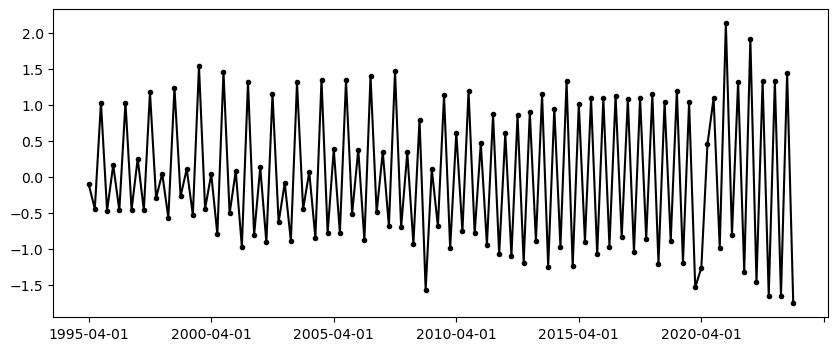

In [183]:
# get data     
data = pd.read_csv(r"../data/a0_combinedQuarterly_new.csv", index_col=[0])
data = data['gdp_total_season'].to_frame()
data['gdp_total_season_diff'] = data['gdp_total_season'].diff()
data.dropna(inplace=True)

scaler = StandardScaler()

columns_Transform = ["gdp_total_season_diff"]
data[columns_Transform] = scaler.fit_transform(data[columns_Transform])
data.columns = [cls + "_stdz" for cls in data.columns]
data['gdp_total_season_diff_stdz'].plot(style=".-", color="k", figsize=(10, 4));

y = data
ar1_data = y['gdp_total_season_diff_stdz'].to_numpy()
print(ar1_data)

## Specify Model

In [184]:
## Set up a dictionary for the specification of our priors
## We set up the dictionary to specify size of the AR coefficients in
## case we want to vary the AR lags.


priors = {
    "coefs": {"mu": [0, -0.4, 0.4], "sigma": [0.2, 0.2, 0.2], "size": 3},
    "sigma": .2,
    "init": {"mu": 0, "sigma": 0.1, "size": 2},
}

## Initialise the model
with pm.Model() as AR:
    pass

## Define the time interval for fitting the data
t_data = list(range(len(ar1_data)))
## Add the time interval as a mutable coordinate to the model to allow for future predictions
AR.add_coord("obs_id", t_data, mutable=True)

with AR:
    ## Data containers to enable prediction
    t_data = pm.Data("t_data", t_data, dims="obs_id")
    y_data = pm.Data("y_data", ar1_data, dims="obs_id")

    # The first coefficient will be the constant term but we need to set priors for each coefficient in the AR process
    coefs = pm.Normal("coefs", priors["coefs"]["mu"], priors["coefs"]["sigma"])
    sigma = pm.HalfNormal("sigma", priors["sigma"])
    # We need one init variable for each lag, hence size is variable too
    init = pm.Normal.dist(
        priors["init"]["mu"], priors["init"]["sigma"], size=priors["init"]["size"]
    )
    # Steps of the AR model minus the lags required
    ar1 = pm.AR(
        "ar",
        coefs,
        sigma=sigma,
        init_dist=init,
        constant=True,
        steps=t.shape[0] - (priors["coefs"]["size"] - 1),
        dims="obs_id",
    )

    # The Likelihood
    outcome = pm.Normal("likelihood", mu=ar1, sigma=sigma, observed=ar1_data, dims="obs_id")
    ## Sampling
    idata_ar = pm.sample_prior_predictive()
    idata_ar.extend(pm.sample(2000, target_accept=0.95))
    idata_ar.extend(pm.sample_posterior_predictive(idata_ar))

/home/jpp/miniconda3/envs/pymc_env/lib/python3.12/site-packages/pymc/model/core.py:999: FutureWarning: Coords are now always mutable. Specifying `mutable` will raise an error in a future release
  warnings.warn(
Sampling: [ar, coefs, likelihood, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coefs, sigma, ar]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7 seconds.
Sampling: [ar, likelihood]


Output()

In [185]:
idata_ar

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

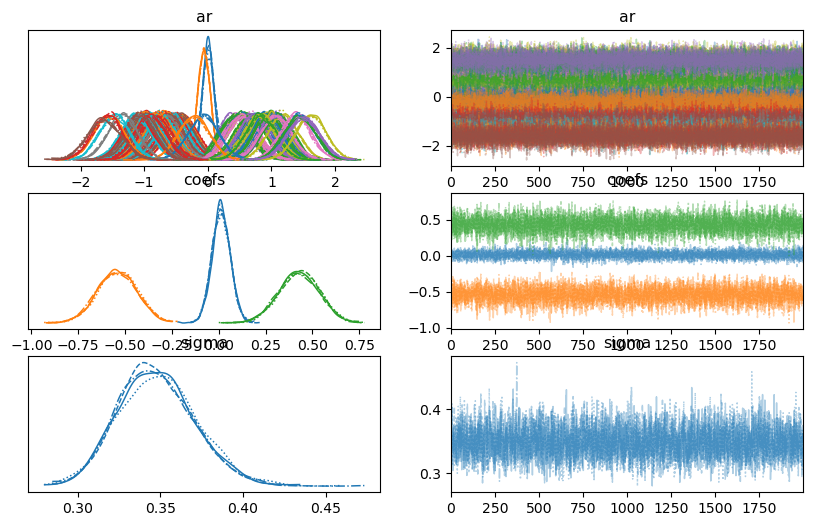

In [186]:
az.plot_trace(idata_ar, figsize=(10, 6));

In [187]:
az.summary(idata_ar, var_names=["~ar"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
coefs[0],0.013,0.049,-0.083,0.101,0.001,0.001,7390.0,5884.0,1.0
coefs[1],-0.542,0.104,-0.732,-0.344,0.002,0.001,4099.0,4918.0,1.0
coefs[2],0.429,0.107,0.239,0.637,0.002,0.001,4164.0,5090.0,1.0
sigma,0.348,0.023,0.305,0.391,0.000,0.000,3029.0,4542.0,1.0


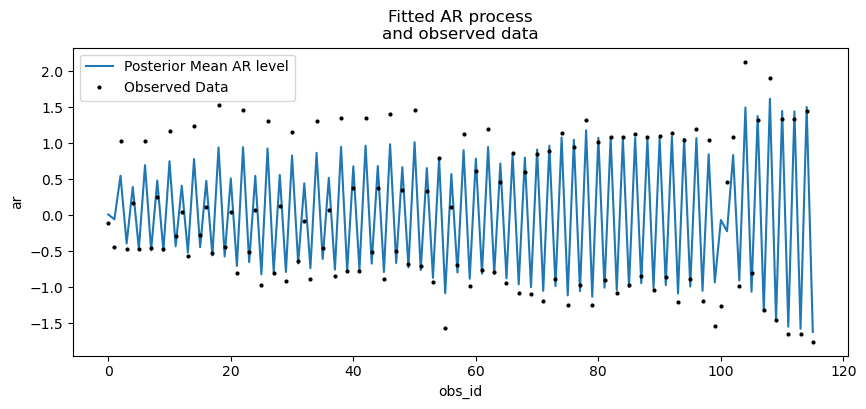

In [188]:
fig, ax = plt.subplots(figsize=(10, 4))
idata_ar.posterior.ar.mean(["chain", "draw"]).plot(ax=ax, label="Posterior Mean AR level")
ax.plot(ar1_data, "o", color="black", markersize=2, label="Observed Data")
ax.legend()
ax.set_title("Fitted AR process\nand observed data");

In [189]:
idata_ar

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

### Prediction Step

In [190]:
prediction_length = 132
n = prediction_length - ar1_data.shape[0]
obs = list(range(prediction_length))
number_lags = 2

with AR:
    ## We need to have coords for the observations minus the lagged term to correctly centre the prediction step
    AR.add_coords({"obs_id_fut_1": range(ar1_data.shape[0] - number_lags, 132, 1)})
    AR.add_coords({"obs_id_fut": range(ar1_data.shape[0], 132, 1)})
    # condition on the learned values of the AR process
    # initialise the future AR process precisely at the last observed value in the AR process
    # using the special feature of the dirac delta distribution to be 0 everywhere else.
    ar1_fut = pm.AR(
        "ar1_fut",
        init_dist=pm.DiracDelta.dist(ar1[..., -1]),
        rho=coefs,
        sigma=sigma,
        constant=True,
        dims="obs_id_fut_1",
    )

    yhat_fut = pm.Normal("yhat_fut", mu=ar1_fut[2:], sigma=sigma, dims="obs_id_fut")
    # use the updated values and predict outcomes and probabilities:
    idata_preds = pm.sample_posterior_predictive(idata_ar, var_names=["likelihood", "yhat_fut"], predictions=True)

Sampling: [ar, ar1_fut, likelihood, yhat_fut]


Output()

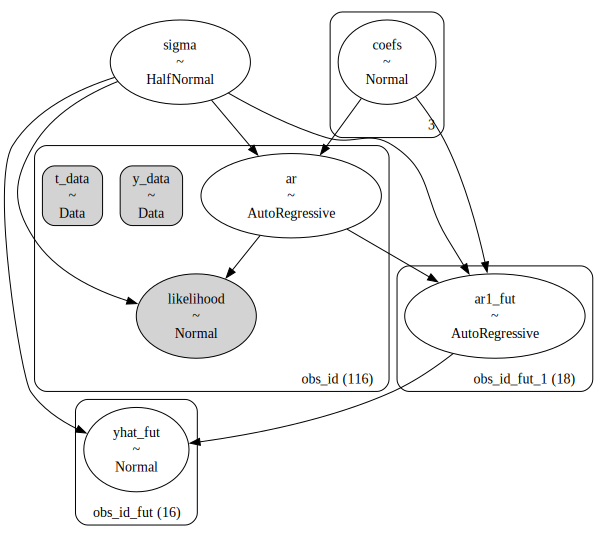

In [191]:
pm.model_to_graphviz(AR)

In [192]:
idata_preds

Inference data with groups:
	> predictions
	> predictions_constant_data

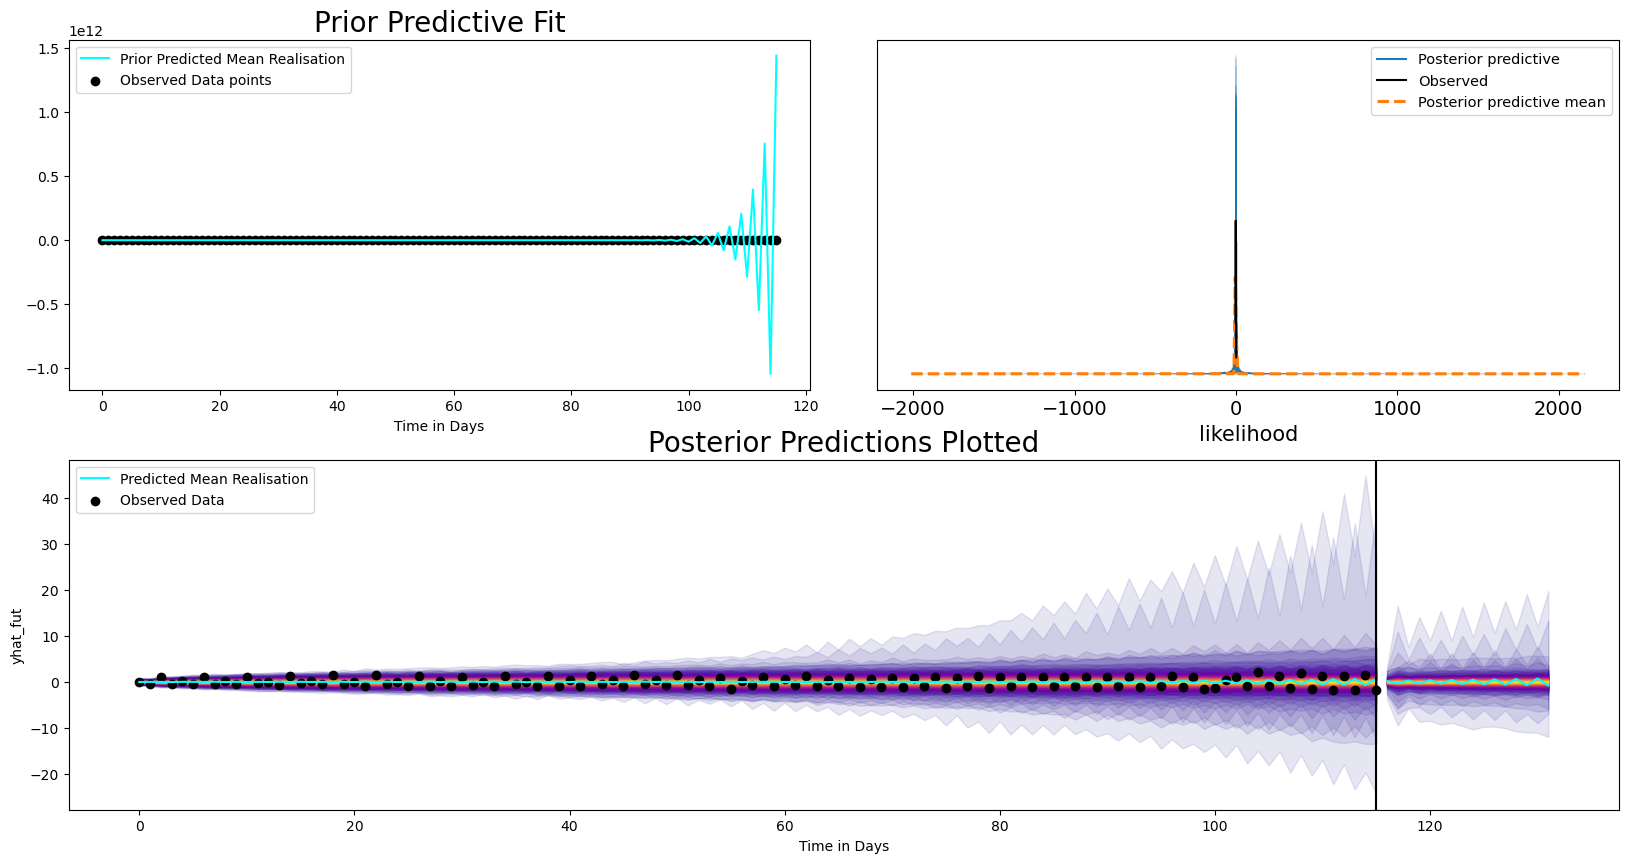

In [193]:
def plot_fits(idata_ar, idata_preds):
    palette = "plasma"
    cmap = plt.get_cmap(palette)
    percs = np.linspace(51, 99, 100)
    colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
    mosaic = """AABB
                CCCC"""
    fig, axs = plt.subplot_mosaic(mosaic, sharex=False, figsize=(20, 10))
    axs = [axs[k] for k in axs.keys()]
    for i, p in enumerate(percs[::-1]):
        upper = np.percentile(
            az.extract(idata_ar, group="prior_predictive", num_samples=1000)["likelihood"],
            p,
            axis=1,
        )
        lower = np.percentile(
            az.extract(idata_ar, group="prior_predictive", num_samples=1000)["likelihood"],
            100 - p,
            axis=1,
        )
        color_val = colors[i]
        axs[0].fill_between(
            x=idata_ar["constant_data"]["t_data"],
            y1=upper.flatten(),
            y2=lower.flatten(),
            color=cmap(color_val),
            alpha=0.1,
        )

    axs[0].plot(
        az.extract(idata_ar, group="prior_predictive", num_samples=1000)["likelihood"].mean(
            axis=1
        ),
        color="cyan",
        label="Prior Predicted Mean Realisation",
    )

    axs[0].scatter(
        x=idata_ar["constant_data"]["t_data"],
        y=idata_ar["constant_data"]["y_data"],
        color="k",
        label="Observed Data points",
    )
    axs[0].set_title("Prior Predictive Fit", fontsize=20)
    axs[0].legend()

    for i, p in enumerate(percs[::-1]):
        upper = np.percentile(
            az.extract(idata_preds, group="predictions", num_samples=1000)["likelihood"],
            p,
            axis=1,
        )
        lower = np.percentile(
            az.extract(idata_preds, group="predictions", num_samples=1000)["likelihood"],
            100 - p,
            axis=1,
        )
        color_val = colors[i]
        axs[2].fill_between(
            x=idata_preds["predictions_constant_data"]["t_data"],
            y1=upper.flatten(),
            y2=lower.flatten(),
            color=cmap(color_val),
            alpha=0.1,
        )

        upper = np.percentile(
            az.extract(idata_preds, group="predictions", num_samples=1000)["yhat_fut"],
            p,
            axis=1,
        )
        lower = np.percentile(
            az.extract(idata_preds, group="predictions", num_samples=1000)["yhat_fut"],
            100 - p,
            axis=1,
        )
        color_val = colors[i]
        axs[2].fill_between(
            x=idata_preds["predictions"].coords["obs_id_fut"].data,
            y1=upper.flatten(),
            y2=lower.flatten(),
            color=cmap(color_val),
            alpha=0.1,
        )

    axs[2].plot(
        az.extract(idata_preds, group="predictions", num_samples=1000)["likelihood"].mean(
            axis=1
        ),
        color="cyan",
    )
    idata_preds.predictions.yhat_fut.mean(["chain", "draw"]).plot(
        ax=axs[2], color="cyan", label="Predicted Mean Realisation"
    )
    axs[2].scatter(
        x=idata_ar["constant_data"]["t_data"],
        y=idata_ar["constant_data"]["y_data"],
        color="k",
        label="Observed Data",
    )
    axs[2].set_title("Posterior Predictions Plotted", fontsize=20)
    axs[2].axvline(np.max(idata_ar["constant_data"]["t_data"]), color="black")
    axs[2].legend()
    axs[2].set_xlabel("Time in Days")
    axs[0].set_xlabel("Time in Days")
    az.plot_ppc(idata_ar, ax=axs[1])


plot_fits(idata_ar, idata_preds)

In [195]:
# Statsmodels AR(2) model
mod = sm.tsa.ARIMA(ar1_data, order=(2, 0, 0), trend="c")
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  116
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 -99.204
Date:                Wed, 25 Sep 2024   AIC                            206.409
Time:                        11:34:42   BIC                            217.423
Sample:                             0   HQIC                           210.880
                                - 116                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0064      0.039      0.166      0.868      -0.069       0.082
ar.L1         -0.6758      0.099     -6.841      0.000      -0.869      -0.482
ar.L2          0.1790      0.107      1.671      0.095      -0.031       0.389
sigma2         0.3205      0.034      9.533      0.000       0.255       0.386
===================================================================================
Ljung-Box (L1) (Q):                   0.69   Jarque-Bera (JB):                25.83
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                            -0.32
Prob(H) (two-sided):                  0.97   Kurtosis:                         5.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

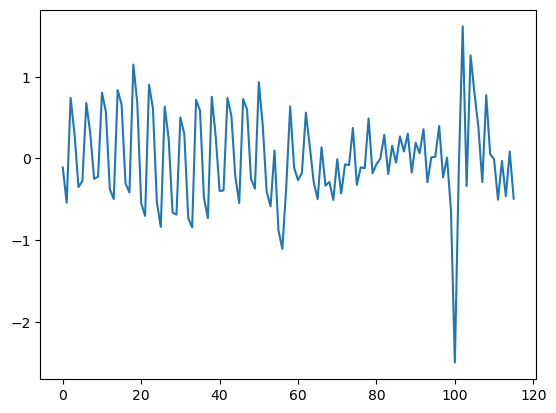

In [198]:
plt.plot(res.resid)